In [1]:
!pip install climetlab==0.8.14
!pip install climetlab-maelstrom-downscaling==0.1.0

Defaulting to user installation because normal site-packages is not writeable
  Using cached climetlab-0.8.14.tar.gz (87 kB)
     |████████████████████████████████| 870 kB 13.8 MB/s eta 0:00:01
  Using cached cfgrib-0.9.10.1-py3-none-any.whl (45 kB)
  Using cached cdsapi-0.5.1.tar.gz (12 kB)
  Using cached ecmwf-api-client-1.6.3.tar.gz (12 kB)
  Using cached eccodes-1.4.2.tar.gz (55 kB)
     |████████████████████████████████| 73.4 MB 24.7 MB/s eta 0:00:01██████        | 54.9 MB 24.7 MB/s eta 0:00:01
     |████████████████████████████████| 8.8 MB 52.9 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 95 kB 3.4 MB/s  eta 0:00:01
  Created wheel for climetlab: filename=climetlab-0.8.14-py3-none-any.whl size=146065 sha256=3eb44d6be4387

In [2]:
import os, sys
import time
import tensorflow.keras as keras
sys.path += ["../handle_data/", "../models", "../postprocess/", "../utils/"]
from handle_data_unet import *
from unet_model import build_unet, get_lr_scheduler
import xarray as xr
import datetime as dt
import json as js

2022-06-26 19:57:00.378642: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# obtain test dataset 
input_dir = "/p/project/deepacf/maelstrom/data/downscaling_unet/"

fopt_norm = os.path.join(input_dir, "opt_norm.json")

with open(fopt_norm) as jfl:
    opt_norm_js = js.load(jfl)

data_obj = HandleUnetData(input_dir, "training", purpose="train_aug")
data_obj.append_data("test", purpose="test_aug")

int_data, tart_data, opt_norm = data_obj.normalize("train_aug", daytime=None)
inte_data, tarte_data = data_obj.normalize("test_aug",  daytime=None, opt_norm=opt_norm_js)

%set_download_flag: Datafiles are already available under '/p/project/deepacf/maelstrom/data/downscaling_unet/'
%get_data: Start reading the data from '/p/project/deepacf/maelstrom/data/downscaling_unet/'...
%get_data: Dataset was retrieved succesfully.
%set_download_flag: Datafiles are already available under '/p/project/deepacf/maelstrom/data/downscaling_unet/'
%get_data: Start reading the data from '/p/project/deepacf/maelstrom/data/downscaling_unet/'...
%get_data: Dataset was retrieved succesfully.


In [5]:
trained_model_dir = "/p/home/jusers/langguth1/juwels/downscaling_maelstrom/downscaling_jsc_repo/downscaling_ap5/trained_models"
model_path = os.path.join(trained_model_dir, "trained_downscaling_unet_t2m_hour12_exp5.h5")
#reconstruct the model
model_recon = keras.models.load_model(model_path)

2022-06-26 20:01:23.366388: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-06-26 20:01:24.216562: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-26 20:01:24.216661: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jwlogin01.juwels): /proc/driver/nvidia/version does not exist
2022-06-26 20:01:24.218838: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-26 20:01:24.244641: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune usi

In [6]:
# create the predictions
y_pred_test = model_recon.predict(inte_data.values, batch_size=32, verbose=2)
y_pred = y_pred_test

if np.ndim(y_pred) == 5:                # cropping necessary if z_branch is True (two output channels)
  y_pred = y_pred[0]
else:
  pass

2022-06-26 20:01:41.819467: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-26 20:01:41.832099: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400000000 Hz


79/79 - 220s


In [7]:
ds_ref = data_obj.data["test_aug"].sel(time=dt.time(12))
var_ref = tarte_data.isel(variable=0)

# get some relevant information from the original dataset, ...
coords = var_ref.squeeze().coords
dims = var_ref.squeeze().dims

# denomralize...
y_pred_trans = np.squeeze(y_pred)*opt_norm["std_tar"].squeeze().values + opt_norm["mu_tar"].squeeze().values
# and make xarray DataArray 
y_pred_trans = xr.DataArray(y_pred_trans, coords=coords, dims=dims, name="t2m_downscaled")

In [ ]:
print(y_pred_trans)

In [8]:
mse_mean, mse_std = np.zeros(7), np.zeros(7)

for i, hh in enumerate(np.arange(10, 17)):
    mse_all = ((y_pred_trans.sel(time=dt.time(hh)) - data_obj.data["test_aug"].sel(time=dt.time(hh))["t2m_tar"])**2).mean(dim=["lat", "lon"])
    mse_mean[i], mse_std[i] = mse_all.mean().values, mse_all.std().values
   


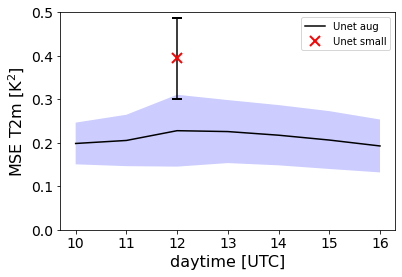

In [9]:
# create plot for evaluation in terms of MSE across daytime (incl. trained model without augmented dataset)

from matplotlib import pyplot as plt

mse_mean = xr.DataArray(mse_mean, coords = {"daytime": np.arange(10,17)}, dims=["daytime"]) 
mse_std = xr.DataArray(mse_std, coords = {"daytime": np.arange(10,17)}, dims=["daytime"])

mse_mean_v, mse_std_v = mse_mean.values, mse_std.values
fig, (ax) = plt.subplots(1,1)
ax.plot(mse_mean["daytime"].values, mse_mean_v, 'k-', label="Unet aug")
ax.fill_between(mse_mean["daytime"].values, mse_mean_v-mse_std_v, mse_mean_v+mse_std_v, facecolor="blue", alpha=0.2)
ax.set_ylim(0., 0.5)
# label axis
ax.set_xlabel("daytime [UTC]", fontsize=16)
ax.set_ylabel("MSE T2m [K$^2$]", fontsize=16)
ax.tick_params(axis="both", which="both", direction="out", labelsize=14)

# add MSE from previous non-augmented dataset
ax.errorbar(12, 0.394, yerr=0.094, fmt='x', capsize=5., ecolor="black", mfc="red",
            mec="red", ms=10, mew=2., label = "Unet small")
# Configure legend
# get handles
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
handles[1] = handles[1][0]

ax.legend(handles, labels, loc='upper right', numpoints=1)
# save plot to file
fig.savefig("downscaling_t2m_mse.png")

In [ ]:
# create plot for specific timesteps
import os, sys
from timeit import default_timer as timer
import datetime as dt
# for processing data
import numpy as np
import xarray as xr
import pandas as pd
# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
# make class for handling data available
sys.path.append("../utils")
from other_utils import provide_default
#from input_data_class import InputDataClass


# further auxiliary functions

# auxiliary function for colormap
def get_colormap_temp(levels=None):
    """
    Get a nice colormap for plotting topographic height
    :param levels: level boundaries
    :return cmap: colormap-object
    :return norm: normalization object corresponding to colormap and levels
    """
    bounds = np.asarray(levels)

    nbounds = len(bounds)
    col_obj = mpl.cm.PuOr_r(np.linspace(0., 1., nbounds))

    # create colormap and corresponding norm
    cmap = mpl.colors.ListedColormap(col_obj, name="temp" + "_map")
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    return cmap, norm, bounds


# for making plot nice
def decorate_plot(ax_plot, plot_xlabel=True, plot_ylabel=True):
    fs = 16
    if True:
    #if "login" in host:
        # add nice coast- and borderlines
        ax_plot.coastlines(linewidth=0.75)
        ax_plot.coastlines(linewidth=0.75)
        ax_plot.add_feature(cartopy.feature.BORDERS)

    # adjust extent and ticks as well as axis-label
    ax_plot.set_xticks(np.arange(0., 360. + 0.1, 5.))  # ,crs=projection_crs)
    ax_plot.set_yticks(np.arange(-90., 90. + 0.1, 5.))  # ,crs=projection_crs)

    ax_plot.set_extent([3.5, 17., 44.5, 55.])#, crs=prj_crs)
    ax_plot.minorticks_on()
    ax_plot.tick_params(axis="both", which="both", direction="out", labelsize=12)

    # some labels
    if plot_xlabel:
        ax_plot.set_xlabel("Longitude [°E]", fontsize=fs)
    if plot_ylabel:
        ax_plot.set_ylabel("Latitude[°N]", fontsize=fs)

    return ax_plot


# for creating plot
def create_plots(data1, data2, opt_plot={}):
    # get coordinate data
    try:
        time, lat, lon = data1["time"].values, data1["lat"].values, data1["lon"].values
        time_stamp = (pd.to_datetime(time)).strftime("%Y-%m-%d %H:00 UTC")
    except Exception as err:
        print("Failed to retrieve coordinates from data1")
        raise err
    # construct array for edges of grid points
    dy, dx = np.round((lat[1] - lat[0]), 2), np.round((lon[1] - lon[0]), 2)
    lat_e, lon_e = np.arange(lat[0]-dy/2, lat[-1]+dy, dy), np.arange(lon[0]-dx/2, lon[-1]+dx, dx)

    title1, title2 = provide_default(opt_plot, "title1", "input T2m"), provide_default(opt_plot, "title2", "target T2m")
    title1, title2 = "{0}, {1}".format(title1, time_stamp), "{0}, {1}".format(title2, time_stamp)
    levels = provide_default(opt_plot, "levels", np.arange(-5., 25., 1.))

    # get colormap
    cmap_temp, norm_temp, lvl = get_colormap_temp(levels)
    # create plot objects
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True,
                                   subplot_kw={"projection": ccrs.PlateCarree()})

    # perform plotting
    temp1 = ax1.pcolormesh(lon_e, lat_e, np.squeeze(data1.values - 273.15), cmap=cmap_temp, norm=norm_temp)
    temp2 = ax2.pcolormesh(lon_e, lat_e, np.squeeze(data2.values - 273.15), cmap=cmap_temp, norm=norm_temp)

    ax1, ax2 = decorate_plot(ax1), decorate_plot(ax2, plot_ylabel=False)

    ax1.set_title(title1, size=14)
    ax2.set_title(title2, size=14)

    # add colorbar
    cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
    cbar = fig.colorbar(temp2, cax=cax, orientation="vertical", ticks=lvl[1::2])
    cbar.ax.tick_params(labelsize=12)

In [ ]:
# choose a time index
tind = 0

y_pred_eval = y_pred_trans.sel(time=dt.time(12))

# plot the full 2m temperature
create_plots(y_pred_eval.isel(time=tind), ds_ref["t2m_tar"].isel(time=tind),
             opt_plot={"title1": "downscaled T2m", "title2": "target T2m"})

diff_in_tar = ds_ref["t2m_in"].isel(time=tind)-ds_ref["t2m_tar"].isel(time=tind) + 273.15
diff_down_tar = y_pred_eval.isel(time=tind)-ds_ref["t2m_tar"].isel(time=tind) + 273.15
create_plots(diff_in_tar, diff_down_tar,
             opt_plot={"title1": "diff. input-target", "title2": "diff. downscaled-target",
                       "levels": np.arange(-3., 3.1, .2)})

In [12]:
from importlib import reload
import other_utils 

reload(other_utils)
str_or_List = Union[List, str]

def check_str_in_list(list_in: List, str2check: str_or_List, labort: bool = True, return_ind: bool = False):
    """
    Checks if all strings are found in list
    :param list_in: input list
    :param str2check: string or list of strings to be checked if they are part of list_in
    :param labort: Flag if error will be risen in case of missing string in list
    :param return_ind: Flag if index for each string found in list will be returned
    :return: True if existence of all strings was confirmed, if return_ind is True, the index of each string in list is
             returned as well
    """
    method = check_str_in_list.__name__

    stat = False
    if isinstance(str2check, str):
        str2check = [str2check]
    elif isinstance(str2check, list):
        assert np.all([isinstance(str1, str) for str1 in str2check]), "Not all elements of str2check are strings"\
                                                                      .format(method)
    else:
        raise ValueError("%{0}: str2check argument must be either a string or a list of strings".format(method))

    stat_element = [True if str1 in list_in else False for str1 in str2check]

    if np.all(stat_element):
        stat = True
    else:
        print("%{0}: The following elements are not part of the input list:".format(method))
        inds_miss = np.where(list(~np.array(stat_element)))[0]
        for i in inds_miss:
            print("* index {0:d}: {1}".format(i, str2check[i]))
        if labort:
            raise ValueError("%{0}: Could not find all expected strings in list.".format(method))
    # return
    if stat and not return_ind:
        return stat
    elif stat:
        return stat, [list_in.index(str_curr) for str_curr in str2check]
    else:
        return stat, []


def calc_spatial_variability(data_fcst, data_ref, **kwargs):
        """
        Calculates the ratio between the spatial variability of differental operator with order 1 (or 2) forecast and
        reference data
        :param data_fcst: data_fcst: forecasted data (xarray with dimensions [batch, fore_hours, lat, lon])
        :param data_ref: reference data (xarray with dimensions [batch, fore_hours, lat, lon])
        :param kwargs: order to control the order of spatial differential operator, 'non_spatial_avg_dims' to perform
                       averaging
        :return: the ratio between spatial variabilty in the forecast and reference data field
        """

        method = calc_spatial_variability.__name__

        avg_dims = ["lat", "lon"]

        if "order" in kwargs:
            order = kwargs.get("order")
        else:
            order = 1
         
        if "non_spatial_avg_dims" in kwargs:
            add_avg_dims = kwargs.get("non_spatial_avg_dims")
        else:
            add_avg_dims = None

        fcst_grad = calc_geo_spatial_diff(data_fcst, order=order)
        ref_grd = calc_geo_spatial_diff(data_ref, order=order)

        ratio_spat_variability = fcst_grad/ref_grd

        if add_avg_dims: ratio_spat_variability = ratio_spat_variability.mean(dim=add_avg_dims)

        return ratio_spat_variability

def calc_geo_spatial_diff(scalar_field: xr.DataArray, order: int = 1, r_e: float = 6371.e3, avg_dom: bool = True):
    """
    Calculates the amplitude of the gradient (order=1) or the Laplacian (order=2) of a scalar field given on a regular,
    geographical grid (i.e. dlambda = const. and dphi=const.)
    :param scalar_field: scalar field as data array with latitude and longitude as coordinates
    :param order: order of spatial differential operator
    :param r_e: radius of the sphere
    :param avg_dom: flag if amplitude is averaged over the domain
    :return: the amplitude of the gradient/laplacian at each grid point or over the whole domain (see avg_dom)
    """
    method = calc_geo_spatial_diff.__name__

    # sanity checks
    assert isinstance(scalar_field, xr.DataArray), "%{0}: scalar_field must be a xarray DataArray, but is '{1}'."\
                                                   .format(method, type(scalar_field))
    assert order in [1, 2], "%{0}: Order must be either 1 or 2.".format(method)

    dims = list(scalar_field.dims)
    lat_dims = ["lat", "latitude"]
    lon_dims = ["lon", "longitude"]

    def check_for_coords(coord_names_data, coord_names_expected):
        for coord in coord_names_expected:
            stat, ind_coord = check_str_in_list(coord_names_data, coord, return_ind=True)
            if stat:
                return ind_coord[0], coord_names_data[ind_coord[0]] # just take the first value

        raise ValueError("%{0}: Could not find one of the following coordinates in the passed dictionary."
                         .format(method, ",".join(coord_names_expected)))

    lat_ind, lat_name = check_for_coords(dims, lat_dims)
    lon_ind, lon_name = check_for_coords(dims, lon_dims)

    lat, lon = np.deg2rad(scalar_field[lat_name]), np.deg2rad(scalar_field[lon_name])

    dphi, dlambda = lat[1].values - lat[0].values, lon[1].values - lon[0].values

    if order == 1:
        dvar_dlambda = 1./(r_e*np.cos(lat)*np.deg2rad(dlambda))*scalar_field.differentiate(lon_name)
        dvar_dphi = 1./(r_e*np.deg2rad(dphi))*scalar_field.differentiate(lat_name)
        dvar_dlambda = dvar_dlambda.transpose(*scalar_field.dims)    # ensure that dimension ordering is not changed

        var_diff_amplitude = np.sqrt(dvar_dlambda**2 + dvar_dphi**2)
        if avg_dom: var_diff_amplitude = var_diff_amplitude.mean(dim=[lat_name, lon_name])
    else:
        raise ValueError("%{0}: Second-order differentation is not implemenetd yet.".format(method))

    return var_diff_amplitude


In [14]:
daytimes = np.arange(10,17)

grad_ratio_mean = xr.DataArray(np.zeros(len(daytimes)), coords={"daytime": daytimes}, dims=["daytime"])
grad_ratio_std = xr.DataArray(np.zeros(len(daytimes)), coords={"daytime": daytimes}, dims=["daytime"])

for i, hh in enumerate(daytimes):
    spat_vari_now = calc_spatial_variability(y_pred_trans.sel(time=dt.time(hh)), \
                                                     data_obj.data["test_aug"]["t2m_tar"].sel(time=dt.time(hh)))
    grad_ratio_mean[i] = np.mean(spat_vari_now)
    grad_ratio_std[i] = np.std(spat_vari_now)

print(grad_ratio_mean)

<xarray.DataArray (daytime: 7)>
array([0.96083692, 0.94474693, 0.92956097, 0.92557336, 0.92917797,
       0.93551772, 0.94019599])
Coordinates:
  * daytime  (daytime) int64 10 11 12 13 14 15 16


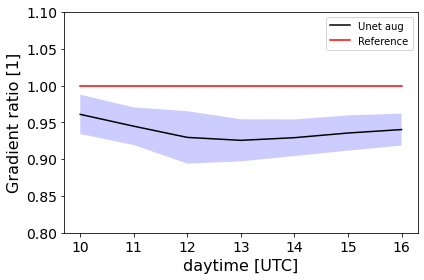

In [21]:
# create plot for evaluation in terms of MSE across daytime (incl. trained model without augmented dataset)

from matplotlib import pyplot as plt

g_rat_v, g_rat_std_v = grad_ratio_mean.values, grad_ratio_std.values
fig, (ax) = plt.subplots(1,1)
ax.plot(grad_ratio_mean["daytime"].values, g_rat_v, 'k-', label="Unet aug")
ax.fill_between(grad_ratio_mean["daytime"].values, g_rat_v-g_rat_std_v, g_rat_v+g_rat_std_v, facecolor="blue", alpha=0.2)
ax.set_ylim(0.8, 1.1)
# label axis
ax.set_xlabel("daytime [UTC]", fontsize=16)
ax.set_ylabel("Gradient ratio [1]", fontsize=16)
ax.tick_params(axis="both", which="both", direction="out", labelsize=14)

# add MSE from previous non-augmented dataset
ax.plot(grad_ratio_mean["daytime"].values, np.ones(len(grad_ratio_mean["daytime"])), 'r-', label="Reference")
#ax.errorbar(12, 0.394, yerr=0.094, fmt='x', capsize=5., ecolor="black", mfc="red",
#            mec="red", ms=10, mew=2., label = "Unet small")
# Configure legend
# get handles
#handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
#handles[1] = handles[1][0]

ax.legend(handles, labels, loc='upper right', numpoints=1)
ax.legend(loc='upper right', numpoints=1)
# tight layout
plt.tight_layout()
# save plot to file
fig.savefig("downscaling_t2m_grad_rat.png")